# **Audio - Configuración 2 - Espectrogramas convertidos en imágenes**

### **Initializations**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
%%capture
!pip install ffmpeg

In [ ]:
%%capture
!unzip "/content/gdrive/My Drive/EmotiW_2018.zip"

In [ ]:
import ffmpeg
import glob, os,shutil

import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray
from numpy import save

import pandas as pd
from google.colab import files
import zipfile
from pathlib import Path

import librosa                    
import librosa.display
import IPython.display as ipd
import scipy.io.wavfile
from scipy.fftpack import dct
from scipy import signal

import operator
import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, BatchNormalization, MaxPooling2D,Activation
from keras import applications
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras import applications
from keras.callbacks import ModelCheckpoint,CSVLogger
from keras import regularizers, optimizers

import sklearn.metrics as sk_metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import itertools

import tensorflow as tf

#sense els imports així passen coses rares:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import Model

import sys
# sys.path.insert(0,'/content/gdrive/MyDrive/Colab Notebooks/test.py')



In [ ]:
# set random seed 
from numpy.random import seed
seed(42)
from tensorflow import random
random.set_seed(42)

In [ ]:
# from numpy.random import seed
# seed(1)

# from tensorflow import random
# random.set_seed(2)

In [ ]:
dict_xy_afew={}
train_set_path='EmotiW_2018/Train_AFEW/'
test_set_path='EmotiW_2018/Val_AFEW/'


In [ ]:
os.remove(train_set_path+'Train_6.xml')
os.remove(train_set_path+'AlignedFaces_LBPTOP_Points.zip')
os.remove(test_set_path+'Val_6.xml')
os.remove(test_set_path+'AlignedFaces_LBPTOP_Points_Val.zip')
emotions=sorted(os.listdir(train_set_path))
print(emotions)

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


In [ ]:
num_emotions=7
emo_dict={}
for emo,i in zip(emotions, range(num_emotions+1)):
  emo_dict[emo]=i
print(emo_dict)
emo_dict_reversed = {v: k for k, v in emo_dict.items()}
print(emo_dict_reversed)

{'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}
{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}


### **Extract audio from videos**

In [ ]:
!rm -rf Test_audio_ne/
!rm -rf Train_audio_ne

In [ ]:
def convert_to_audio_ne(set_path,set_name):
  f = open("convert_to_audio.sh", "w")
  path_afew_set=set_path
  urls_afew = glob.glob(pathname=path_afew_set + '*')
  print(urls_afew)
  print("-------------------")
  for url_emo in urls_afew:
    urls_emotion = glob.glob(pathname=url_emo + '/*')
    # print(urls_emotion)
    emo=os.path.basename(url_emo)
    new_dir=set_name+'_audio_ne/'
    if not os.path.exists(set_name+'_audio_ne'):
      os.makedirs(set_name+'_audio_ne')
    print(emo)
    for video_file in urls_emotion:
      pass
      file_name=os.path.splitext(os.path.basename(video_file))
      f.write("ffmpeg -i "+video_file+" -vn -ac 1 "+new_dir+file_name[0]+".wav"+'\n')
      dict_xy_afew[file_name[0]]=emo
  f.close()

In [ ]:
%%capture
#Extraemos el audio de los vídeos del AFEW
!rm -rf Train_audio_ne
convert_to_audio_ne(train_set_path,'Train')
! bash convert_to_audio.sh
!rm -rf Test_audio_ne
convert_to_audio_ne(test_set_path,'Test')
! bash convert_to_audio.sh

In [ ]:
# train_path='gdrive/MyDrive/Audio_TFM/Train_audio_ne/'
# test_path='gdrive/MyDrive/Audio_TFM/Test_audio_ne/'


In [ ]:
train_path='Train_audio_ne/'
test_path='Test_audio_ne/'

In [ ]:
urls_afew_train = glob.glob(pathname=train_path + '*')
urls_afew_test = glob.glob(pathname=test_path + '*')
urls_afew_test[0]

'Test_audio_ne/000633000.wav'

In [ ]:
print("number of train samples:",len(urls_afew_train))
print("number of test samples:",len(urls_afew_test))

number of train samples: 773
number of test samples: 381


emotion:  Angry
number of audios:  197
-----
emotion:  Disgust
number of audios:  113
-----
emotion:  Fear
number of audios:  127
-----
emotion:  Happy
number of audios:  213
-----
emotion:  Neutral
number of audios:  205
-----
emotion:  Sad
number of audios:  177
-----
emotion:  Surprise
number of audios:  120
-----


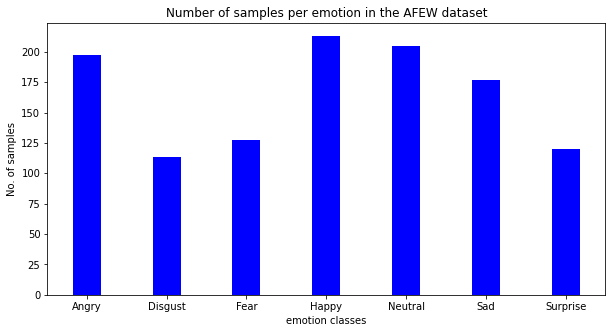

In [ ]:
emotions=[]
num_samples=[]
for emo in emo_dict.keys():
  samples=list(dict_xy_afew.values()).count(emo)
  num_samples.append(samples)
  emotions.append(emo)
  print("emotion: ", emo)
  print("number of audios: ",samples)
  print("-----")

#Está desbalanceado. Graficamos la distribución por clases:

fig = plt.figure(figsize = (10, 5))
plt.bar(emotions, num_samples, 
        0.35,label="number of samples",color ='blue')
plt.xlabel("emotion classes")
plt.ylabel("No. of samples")
plt.title("Number of samples per emotion in the AFEW dataset")
plt.show()

In [ ]:
def get_categorical_label(file_id):
  emo=dict_xy_afew[file_id]
  categorical_label=tf.keras.utils.to_categorical(emo_dict[emo], num_classes=num_classes)
  return categorical_label

def get_emo_label(categorical_label):
  emo=dict_xy_afew[file_id]
  return emo

def get_emo_from_categorical(label):
  idx=list(label).index(1)
  return emo_dict_reversed[idx]

def plot_model(history,title):
  fig=plt.figure()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  # plt.plot(history.history['val_categorical_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.title("model train and val accuracy "+title)
  
  plt.figure()
  plt.plot(history.history['val_accuracy'])
  plt.title("Validation accuracy " + title)
  plt.show()

def save_plot(history,title,filename="/content/gdrive/My Drive/TFM_MUSI/Audio/Results/"):
  fig = plt.figure()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  # plt.plot(history.history['val_categorical_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.title("model train and val accuracy "+title)
  plt.show()
  new_filename  = Path(filename +'/'+title+'.jpg')
  fig.savefig(new_filename, dpi=400, bbox_inches='tight',pad_inches=0)

def plot_conf_matrix(test_set,modelo,path,title,standard_format=True,percentages=True,save_plot=True):
  y_true=test_set.labels
  print(len(y_true))
  labels=[key for key in test_set.class_indices.keys()]
  predictions=modelo.predict(test_set)
  ypred=[round(list(i).index(max(i))) for i in predictions]
  print(confusion_matrix(test_set.classes, ypred)[:,:])
  print("")
  f1=f1_score(y_true, ypred,average=None)
  f1_w=f1_score(y_true, ypred,average='weighted')
  ac=accuracy_score(y_true, ypred)
  print("accuracy: ",ac)
  print("f1 score:",f1)
  print("f1 score weighted:",f1_w)
  print("---------------------------------------------------------")
  print(title)
  if standard_format:

    cm = confusion_matrix(y_true, ypred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues,xticks_rotation='vertical',values_format='d')
    if save_plot:
      plt.savefig(path+".png")
    plt.show()
  print("")
  if standard_format:

    cm = confusion_matrix(y_true, ypred,normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues,xticks_rotation='vertical',values_format='.2f')
    plt.show()
    if save_plot:
      plt.savefig(path+"_perctg.png")
    plt.show()
  print("")

### **Create spectrograms and convert them to images**

In [ ]:
#Directori per els espectrogrames convertits en imatge
! rm -rf spec_images
os.mkdir('spec_images/')
sets=["train","test"]
for partition in sets:
  os.mkdir('spec_images/'+partition+"/")
  for emotion in emo_dict.keys():
    os.mkdir('spec_images/'+partition+"/"+ emotion)


In [ ]:
#Convertir a spectrograma i guardar como imagen
def create_spectrogram_test(filename,saving_file,preemphasis=False):
    plt.interactive(False)
    audio, sample_rate = librosa.load(filename, sr=None)
    if preemphasis==True: 
      audio=librosa.effects.preemphasis(audio, coef=0.97) #Apply a pre-emphasis filter
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    #Espectrograma bàsic:
    S = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    new_filename  = Path(saving_file + '.jpg')
    fig.savefig(new_filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    

In [ ]:
#Convertir los audios en imágenes de espectrogramas:
for audio_file in urls_afew_test:
  file_id=os.path.split(audio_file)[1].split(".")[0]
  label=dict_xy_afew[file_id]
  saving_file="spec_images/test/"+label+"/"+file_id
  create_spectrogram_test(audio_file,saving_file)

for audio_file in urls_afew_train:
  file_id=os.path.split(audio_file)[1].split(".")[0]
  label=dict_xy_afew[file_id]
  saving_file="spec_images/train/"+label+"/"+file_id
  create_spectrogram_test(audio_file,saving_file)


In [ ]:
train_dir= '/content/spec_images/train'
test_dir= '/content/spec_images/test'
# val_dir= '/content/spec_images/val'

def create_sets(train_dir,test_dir,batch_size):

  datagen=ImageDataGenerator(rescale=1./255.)

  train_generator=datagen.flow_from_directory(
      train_dir,
      batch_size=batch_size,
      seed=42,
      shuffle=True,
      class_mode="categorical",
      classes=["Angry" , "Disgust","Fear" ,"Happy","Neutral" ,"Sad","Surprise"],
      target_size=(64,64))

  # valid_generator=datagen.flow_from_directory(
  #     val_dir,
  #     batch_size=32,
  #     seed=42,
  #     shuffle=True,
  #     class_mode="categorical",
  #     target_size=(64,64))

  test_generator=datagen.flow_from_directory(
      test_dir,
      batch_size=batch_size,
      seed=42,
      shuffle=False,
      class_mode="categorical",
      classes=["Angry" , "Disgust","Fear" ,"Happy","Neutral" ,"Sad","Surprise"],
      target_size=(64,64))
  
  return train_generator,test_generator

train_generator,test_generator=create_sets(train_dir,test_dir,batch_size)


Found 773 images belonging to 7 classes.
Found 381 images belonging to 7 classes.


In [ ]:
#Fins aquíí per carregar dades i generar sets

### **Models**

In [ ]:
#Testeamos los 3 modelos con las imágenes de los espectrogramas

In [ ]:
DROPOUT=0.5
l2_regul=0.001
N_OUTPUT_LABELS=7
batch_size=16
epochs=50
# desired_audio_len=131771 # 8997
# preemphasis=False
# normalize=False
num_classes=7
lr=0.0001
input_shape=(64,64,3) 
train_generator,test_generator=create_sets(train_dir,test_dir,batch_size)
# filepath="/content/gdrive/MyDrive/TFM_MUSI/combined_model"
# path=filepath+":{epoch:03d}-val_accuracy:{val_accuracy:.3f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# callbacks_list=[checkpoint,E_stopping]

Found 773 images belonging to 7 classes.
Found 381 images belonging to 7 classes.


In [ ]:
#Modelo 1: US model:

In [ ]:
#US model
def model1():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same',
                  input_shape=(64,64,3)))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))
  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(128, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(7, activation='softmax'))
  return model
audio_model_US=model1()
audio_model_US.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
activation_14 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 62, 62, 64)        18496     
_________________________________________________________________
activation_15 (Activation)   (None, 62, 62, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 31, 31, 64)       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
48/48 [==============================] - 4s 58ms/step - loss: 1.9438 - accuracy: 0.1546 - val_loss: 1.9876 - val_accuracy: 0.1658
Epoch 2/60
48/48 [==============================] - 2s 49ms/step - loss: 1.9264 - accuracy: 0.1783 - val_loss: 1.9259 - val_accuracy: 0.1712
Epoch 3/60
48/48 [==============================] - 2s 49ms/step - loss: 1.9210 - accuracy: 0.1836 - val_loss: 1.9220 - val_accuracy: 0.1658
Epoch 4/60
48/48 [==============================] - 2s 48ms/step - loss: 1.9225 - accuracy: 0.1889 - val_loss: 1.9211 - val_accuracy: 0.1712
Epoch 5/60
48/48 [==============================] - 2s 49ms/step - loss: 1.9109 - accuracy: 0.1863 - val_loss: 1.9184 - val_accuracy: 0.1739
Epoch 6/60
48/48 [==============================] - 2s 49ms/step - loss: 1.9045 - accuracy: 0.2074 - val_loss: 1.8914 - val_accuracy: 0.2337
Epoch 7/60
48/48 [==============================] - 2s 49ms/step - loss: 1.8892 - accuracy: 0.2272 - val_loss: 1.8931 - val_accuracy: 0.2065
Epoch 8/60
48

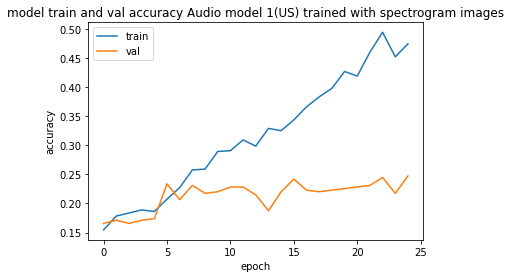

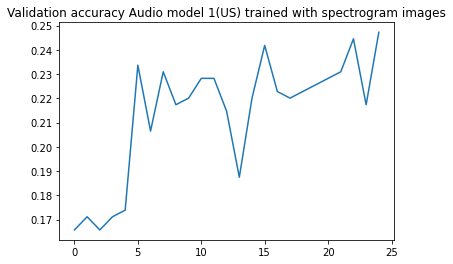

381
[[46  0  0 10  5  3  0]
 [16  0  0 13 10  1  0]
 [13  0  0 26  6  1  0]
 [32  0  0 22  8  1  0]
 [24  1  0 22 12  2  0]
 [21  0  0 21 18  1  0]
 [15  0  0 26  3  2  0]]

accuracy:  0.2125984251968504
f1 score: [0.3982684  0.         0.         0.21674877 0.19512195 0.02777778
 0.        ]
f1 score weighted: 0.13842843404673302
---------------------------------------------------------
Audio model 1(US) trained with spectrogram images


<Figure size 432x288 with 0 Axes>

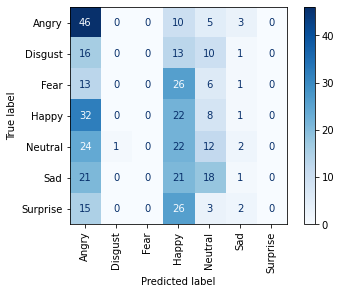

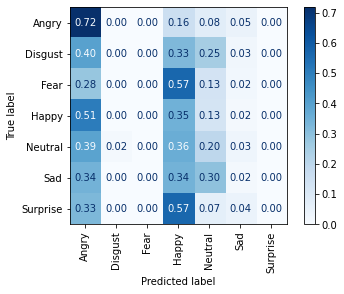

<Figure size 432x288 with 0 Axes>

In [ ]:
audio_model_US=model1()

audio_model_US.compile(tf.optimizers.RMSprop(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0,patience=15,verbose=1,mode="auto",restore_best_weights=True)
callbacks_list=[E_stopping]

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

history=audio_model_US.fit_generator(generator=train_generator,
                                  steps_per_epoch=STEP_SIZE_TRAIN,
                                  validation_data=test_generator,
                                  validation_steps=STEP_SIZE_TEST,
                                  epochs=60,
                                  callbacks=callbacks_list)
path=""
plot_model(history,"Audio model 1(US) trained with spectrogram images")
title="Audio model 1(US) trained with spectrogram images"
plt.figure()
plot_conf_matrix(test_generator,audio_model_US,path,title,standard_format=True,percentages=True,save_plot=True)

In [ ]:
#Modelo 2: Fayek

In [ ]:
def Classifier():
    model = Sequential()

    model.add(Conv2D(filters=16,
                     kernel_size=(10, 10),
                     strides=2,
                     activation='relu',
                     input_shape=input_shape, kernel_regularizer=regularizers.l2(l2_regul)))
    
    model.add(BatchNormalization())

    model.add(Conv2D(filters=32,
                     kernel_size=(10, 10),
                     strides=2,
                     activation='relu',
                     kernel_regularizer=regularizers.l2(l2_regul)))
    
    model.add(BatchNormalization())

    #Afegit això:
    # model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Flatten())
    
    model.add(Dense(units=716,activation='relu'))

    model.add(BatchNormalization())
    model.add(Dropout(DROPOUT))

    model.add(Dense(units=716,activation='relu'))

    model.add(BatchNormalization())
    model.add(Dropout(DROPOUT))

    model.add(Dense(units=716,activation='softmax'))
    
    model.add(BatchNormalization())
    model.add(Dropout(DROPOUT))
    # model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dense(units=N_OUTPUT_LABELS,
                    activation='softmax'))
    return model


audio_model = Classifier()


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
48/48 [==============================] - 5s 51ms/step - loss: 1.9723 - categorical_accuracy: 0.1546 - accuracy: 0.1546 - val_loss: 1.9671 - val_categorical_accuracy: 0.1712 - val_accuracy: 0.1712
Epoch 2/60
48/48 [==============================] - 2s 44ms/step - loss: 1.9638 - categorical_accuracy: 0.1704 - accuracy: 0.1704 - val_loss: 1.9637 - val_categorical_accuracy: 0.1712 - val_accuracy: 0.1712
Epoch 3/60
48/48 [==============================] - 2s 44ms/step - loss: 1.9404 - categorical_accuracy: 0.2034 - accuracy: 0.2034 - val_loss: 1.9610 - val_categorical_accuracy: 0.1712 - val_accuracy: 0.1712
Epoch 4/60
48/48 [==============================] - 2s 44ms/step - loss: 1.9346 - categorical_accuracy: 0.1929 - accuracy: 0.1929 - val_loss: 1.9589 - val_categorical_accuracy: 0.1712 - val_accuracy: 0.1712
Epoch 5/60
48/48 [==============================] - 2s 46ms/step - loss: 1.9306 - categorical_accuracy: 0.2246 - accuracy: 0.2246 - val_loss: 1.9568 - val_categorical_accur

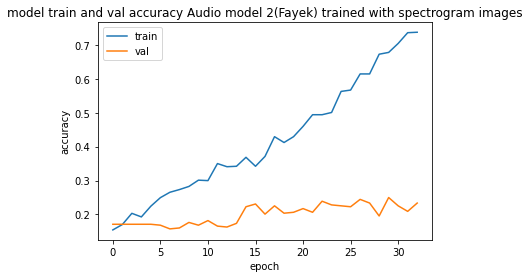

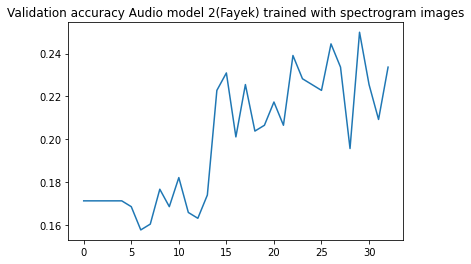

381
[[25  0  0 17 13  9  0]
 [ 5  0  0 18 15  2  0]
 [ 4  0  4 16 20  2  0]
 [ 7  0  5 21 27  3  0]
 [ 6  0  0 21 32  2  0]
 [11  0  0 21 28  1  0]
 [ 4  0  1 18 19  4  0]]

accuracy:  0.2178477690288714
f1 score: [0.3968254  0.         0.14285714 0.21538462 0.29767442 0.02380952
 0.        ]
f1 score weighted: 0.170992139697505
---------------------------------------------------------
Audio model 2(Fayek) trained with spectrogram images


<Figure size 432x288 with 0 Axes>

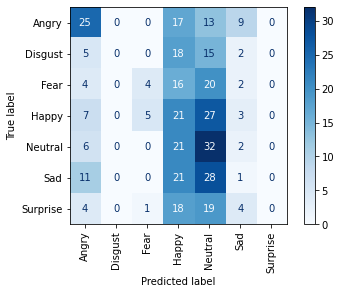

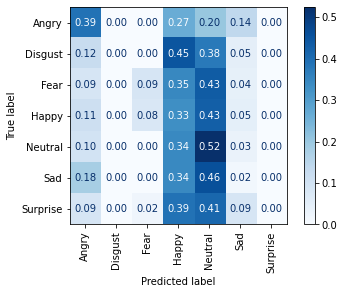

<Figure size 432x288 with 0 Axes>

In [ ]:
audio_model_fayek = Classifier()
E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0,patience=15,verbose=1,mode="auto",restore_best_weights=True)
callbacks_list=[E_stopping]

optimizer = tf.keras.optimizers.RMSprop(lr=lr)
audio_model_fayek.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy'])

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

history=audio_model_fayek.fit_generator(generator=train_generator,
                                  steps_per_epoch=STEP_SIZE_TRAIN,
                                  validation_data=test_generator,
                                  validation_steps=STEP_SIZE_TEST,
                                  epochs=60,
                                  callbacks=callbacks_list)
path=""
plot_model(history,"Audio model 2(Fayek) trained with spectrogram images")
title="Audio model 2(Fayek) trained with spectrogram images"
plt.figure()
plot_conf_matrix(test_generator,audio_model_fayek,path,title,standard_format=True,percentages=True,save_plot=True)



In [ ]:
# modelo 3: VGG16 fine-tuning last conv block

In [ ]:
def create_model(num_frozen_layers=8,dropout=None):
  model = VGG16(include_top=False,weights="imagenet", input_shape=(img_width, img_height, 3))
  print("VGG_summary:")
  # model.summary()
  # add new classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  dense1 = Dense(1024, activation='relu')(flat1)
  if dropout!=None:
    dropout=Dropout(dropout)(dense1)
    output = Dense(7, activation='softmax')(dropout)
  else:
    output = Dense(7, activation='softmax')(dense1)
  # define new model
  new_model = Model(inputs=model.inputs, outputs=output)
  print(new_model.layers)
  for layer in new_model.layers[0:-8]:
    print("freezing layer: ",layer.name)
    layer.trainable = False
  print("new_model summary!")
  new_model.summary()
  return new_model

model_VGG_audio=create_model(8,dropout=0.5)

VGG_summary:
[<keras.engine.input_layer.InputLayer object at 0x7f479c2c9390>, <keras.layers.convolutional.Conv2D object at 0x7f479c388110>, <keras.layers.convolutional.Conv2D object at 0x7f48179dc4d0>, <keras.layers.pooling.MaxPooling2D object at 0x7f479c388090>, <keras.layers.convolutional.Conv2D object at 0x7f479c343410>, <keras.layers.convolutional.Conv2D object at 0x7f479c2ebe90>, <keras.layers.pooling.MaxPooling2D object at 0x7f479c2dd810>, <keras.layers.convolutional.Conv2D object at 0x7f479c2f3610>, <keras.layers.convolutional.Conv2D object at 0x7f479c2e9950>, <keras.layers.convolutional.Conv2D object at 0x7f479c2d94d0>, <keras.layers.pooling.MaxPooling2D object at 0x7f479c303850>, <keras.layers.convolutional.Conv2D object at 0x7f479c2fb210>, <keras.layers.convolutional.Conv2D object at 0x7f479c2ecd10>, <keras.layers.convolutional.Conv2D object at 0x7f479c304210>, <keras.layers.pooling.MaxPooling2D object at 0x7f479c297050>, <keras.layers.convolutional.Conv2D object at 0x7f479c2

**Figura 18:** Resultados de utilizar la VGG16 con espectrogra-mas convertidos en imágenes

In [ ]:
model3.compile(loss='categorical_crossentropy',
                optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                metrics=['accuracy','categorical_accuracy'])


path=filepath+"VGGTEST"+":{epoch:03d}-val_accuracy:{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                              min_delta=0,
                                              patience=30,
                                              verbose=1,
                                              mode="auto",
                                              restore_best_weights=True)
  # WandbCallbacks=WandbCallback(
  #               monitor='val_loss',
  #               verbose=1,
  #               mode='auto',
  #               generator=test_set,
  #               validation_steps=nb_test_samples // batch_size,
  #               input_type="image",
  #               labels=['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])

callbacks_list = [checkpoint,E_stopping]


STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
# STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history=model3.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_generator,
                    validation_steps=STEP_SIZE_TEST,
                    epochs=100,
                    callbacks=callback_list)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
24/24 [==============================] - 5s 108ms/step - loss: 2.1293 - accuracy: 0.1486 - categorical_accuracy: 0.1486 - val_loss: 1.9401 - val_accuracy: 0.1591 - val_categorical_accuracy: 0.1591

Epoch 00001: val_accuracy did not improve from 0.26136
Epoch 2/100
24/24 [==============================] - 2s 66ms/step - loss: 2.0099 - accuracy: 0.1588 - categorical_accuracy: 0.1588 - val_loss: 1.9177 - val_accuracy: 0.2131 - val_categorical_accuracy: 0.2131

Epoch 00002: val_accuracy did not improve from 0.26136
Epoch 3/100
24/24 [==============================] - 2s 66ms/step - loss: 2.0197 - accuracy: 0.2055 - categorical_accuracy: 0.2055 - val_loss: 1.9105 - val_accuracy: 0.2017 - val_categorical_accuracy: 0.2017

Epoch 00003: val_accuracy did not improve from 0.26136
Epoch 4/100
24/24 [==============================] - 2s 65ms/step - loss: 1.9781 - accuracy: 0.2390 - categorical_accuracy: 0.2390 - val_loss: 1.9058 - val_accuracy: 0.2216 - val_categorical_accuracy: 0.2216

<Figure size 432x288 with 0 Axes>

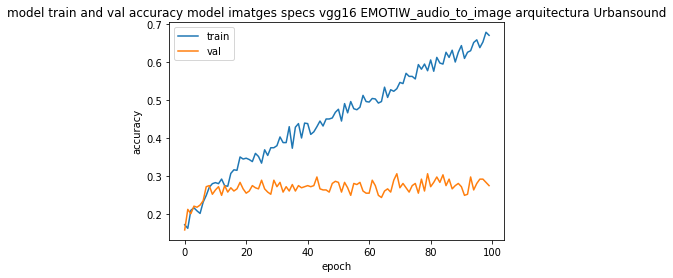

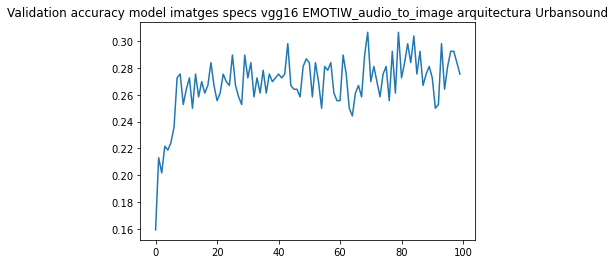

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_model(history,"model imatges specs vgg16 EMOTIW_audio_to_image arquitectura Urbansound")
plt.figure()

In [ ]:
model3.save("/content/gdrive/MyDrive/TFM_MUSI/combined_model/model3imatgespecsVGG16.h5")

In [ ]:
model3=keras.models.load_model("/content/gdrive/MyDrive/TFM_MUSI/combined_model/model3imatgespecsVGG16.h5")

381
[[31  3  1 22  3  4  0]
 [ 8  6  1 13  4  8  0]
 [ 8  2  9 16  4  4  3]
 [10  6  6 26  5  9  1]
 [10  4  2 26 15  4  0]
 [ 7  5  8 16  7 13  5]
 [ 6  1  4 18  7  5  5]]

accuracy:  0.2755905511811024
f1 score: [0.43055556 0.17910448 0.23376623 0.26       0.28301887 0.24074074
 0.16666667]
f1 score weighted: 0.26632279319823626
---------------------------------------------------------
vgg16 last conv block fine-tuned audio spectrogram images


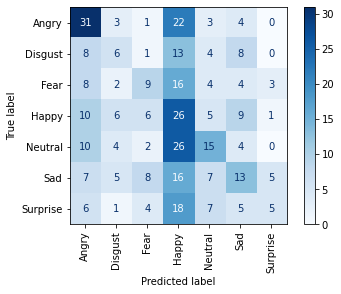

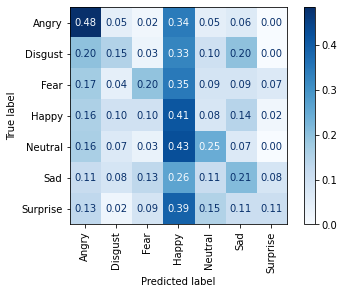

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_conf_matrix(test_generator,model3,path,title,standard_format=True,percentages=True,save_plot=True)

### **Save predictions**

In [ ]:
#Load model and save predictions:


In [ ]:
audio_vgg_model=keras.models.load_model("/content/gdrive/MyDrive/TFM_MUSI/combined_model/model3imatgespecsVGG16.h5")

In [ ]:
from keras.preprocessing.image import img_to_array
vgg_audio_model_preds_test={}
dir= "/content/spec_images/test/"

for emotion in os.listdir(dir):
  emotion_label=emotion
  for img_path in glob.glob(dir+emotion+"/*"):
    video_id= img_path.split("/")[-1].split(".")[0]
    
    # print(video_id)
    img=tf.keras.preprocessing.image.load_img(img_path, color_mode="rgb",target_size=(64,64))
    x = img_to_array(img)
    x=x/255.
    # new_x=tf.expand_dims(x, axis=0)
    input = np.array([x]) 
    y=audio_vgg_model.predict(input)
    vgg_audio_model_preds_test[video_id]=y
      # print(y)

In [ ]:

a_file = open("vgg_audio_model_preds_train.pkl", "rb")
output = pickle.load(a_file)

# print(output)
print(output.keys())
output["000149120"]

dict_keys(['005013327', '003634414', '002221960', '002631920', '002842814', '003127040', '010301054', '005153760', '000407350', '004438800', '001635160', '002516320', '001802480', '011306940', '000256440', '001641600', '005951680', '001404920', '001817880', '000419314', '002408334', '004944560', '001134360', '004020574', '005826400', '005515200', '011329120', '002934807', '001012520', '001653480', '000123880', '002650134', '001636600', '012535447', '010255520', '014527960', '001850640', '004406878', '003902287', '000758680', '004511694', '004025454', '004524480', '004141320', '015646720', '012246840', '000403327', '010316167', '001130680', '014246120', '001010160', '001422600', '013036534', '005122167', '011810688', '002137920', '002607280', '003033040', '010212354', '001100640', '000404000', '003555207', '002809954', '010732287', '001748200', '005805120', '011409414', '004415287', '001949614', '011434920', '000147200', '013818854', '012949687', '011411334', '002441440', '001703120', '

array([[0.60835004, 0.01976722, 0.03364116, 0.14789636, 0.00358232,
        0.0755593 , 0.11120356]], dtype=float32)

In [ ]:
import pickle
a_file = open("vgg_audio_model_preds_train.pkl", "wb")
pickle.dump(vgg_audio_model_preds_train, a_file)
a_file.close()



In [ ]:
from keras.preprocessing.image import img_to_array
vgg_audio_model_preds_train={}
dir= "/content/spec_images/train/"
for emotion in os.listdir(dir):
  emotion_label=emotion
  for img_path in glob.glob(dir+emotion+"/*"):
    video_id= img_path.split("/")[-1].split(".")[0]
    
    print(video_id)
    img=tf.keras.preprocessing.image.load_img(img_path, color_mode="rgb",target_size=(64,64))
    x = img_to_array(img)
    x=x/255.
    # new_x=tf.expand_dims(x, axis=0)
    input = np.array([x]) 
    y=audio_vgg_model.predict(input)
    vgg_audio_model_preds_train[video_id]=y
      # print(y)



000455174
001759754
010123320
003343120
001548120
011809840
012101720
011603980
003723054
000643974
014003120
005153760
000945960
001905680
004603760
004029240
003150857
002728760
014012360
002519000
004605760
004545840
002652360
002523280
004601560
015143720
000157760
013437680
010620040
000652814
005913697
012341120
003133720
001610960
003707080
011737720
003256320
003637840
002315574
003715767
000311160
011603080
003314534
001545760
005409240
000102534
012554740
001913160
015337240
004319360
012726680
003421880
003609600
003440294
000851240
011549760
004407487
000353800
002518734
010615240
005841913
011631117
001947263
011018537
005014520
002712120
000749320
010340280
003118400
000252168
003403857
005242000
001549320
003420687
002730440
003539527
010148720
003029120
002818854
002400680
000456960
003907774
001555320
001138040
003229280
003722087
001954560
005912080
001805320
001815600
002252017
001846360
010659200
004612800
012257440
013557320
010102537
001305160
001335200
010401800


In [ ]:
vgg_audio_model_preds

{'000029301': array([[0.33727592, 0.061107  , 0.13111374, 0.07845227, 0.31551626,
         0.02788351, 0.04865132]], dtype=float32),
 '000046280': array([[0.85034055, 0.01482317, 0.00799557, 0.03190882, 0.06464822,
         0.02192642, 0.00835719]], dtype=float32),
 '000059880': array([[0.03860563, 0.03590162, 0.04052533, 0.49913394, 0.24361953,
         0.06628133, 0.07593258]], dtype=float32),
 '000102534': array([[0.22244067, 0.01709715, 0.08912706, 0.19887325, 0.01088525,
         0.03735815, 0.42421848]], dtype=float32),
 '000141494': array([[0.07355081, 0.06367894, 0.02595417, 0.21306197, 0.08404525,
         0.4657565 , 0.07395232]], dtype=float32),
 '000143240': array([[0.02430893, 0.05883965, 0.02306355, 0.60192144, 0.18028127,
         0.02318868, 0.08839653]], dtype=float32),
 '000150854': array([[0.12616943, 0.03468928, 0.36979255, 0.15665187, 0.00262943,
         0.21201761, 0.09804984]], dtype=float32),
 '000157760': array([[0.04896033, 0.13348922, 0.13910589, 0.15945727,

In [ ]:
# VECTOR DE FEATURES PARA EL MODELO COMBINADO GUARDADO

In [ ]:
#-------------------------- FIN DE LA EVALUACIÓN DE LAS MEJORES COMBINACIONES DE PARÁMETROS PARA LOS MODELOS----------------------------------------------

In [ ]:
#Algún otro test no eliminado:

### Otros tests

In [ ]:
model=model1()
model.compile(optimizers.RMSprop(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

In [ ]:
callback_list = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=35)

**Figura 16:** Resultados de utilizar la arquitectura 2 con espec-trogramas convertidos en imágenes

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
# STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history=model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_generator,
                    validation_steps=STEP_SIZE_TEST,
                    epochs=100,
                    callbacks=callback_list)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
24/24 [==============================] - 3s 81ms/step - loss: 1.9452 - accuracy: 0.1731 - val_loss: 1.9356 - val_accuracy: 0.1619
Epoch 2/100
24/24 [==============================] - 2s 64ms/step - loss: 1.9180 - accuracy: 0.1922 - val_loss: 1.9339 - val_accuracy: 0.1562
Epoch 3/100
24/24 [==============================] - 2s 65ms/step - loss: 1.9281 - accuracy: 0.1840 - val_loss: 1.9325 - val_accuracy: 0.1619
Epoch 4/100
24/24 [==============================] - 2s 65ms/step - loss: 1.9142 - accuracy: 0.1841 - val_loss: 1.9378 - val_accuracy: 0.1506
Epoch 5/100
24/24 [==============================] - 2s 71ms/step - loss: 1.9050 - accuracy: 0.1780 - val_loss: 1.9247 - val_accuracy: 0.1648
Epoch 6/100
24/24 [==============================] - 2s 66ms/step - loss: 1.9264 - accuracy: 0.1891 - val_loss: 1.9307 - val_accuracy: 0.1761
Epoch 7/100
24/24 [==============================] - 2s 65ms/step - loss: 1.9242 - accuracy: 0.1754 - val_loss: 1.9334 - val_accuracy: 0.1562
Epoch 

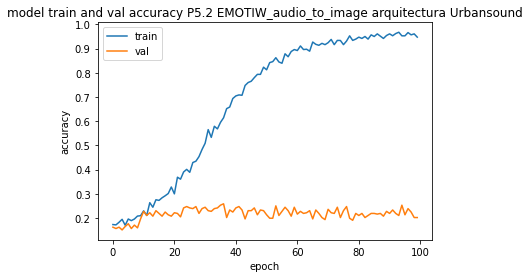

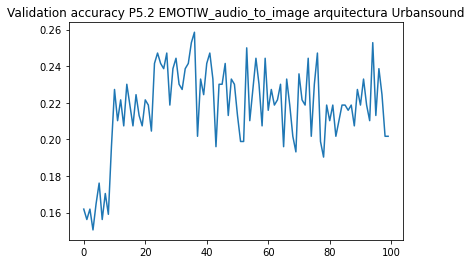

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_model(history,"P5.2 EMOTIW_audio_to_image arquitectura Urbansound")
plt.figure()
# plt.plot(history.history["validation_accuracy"])


In [ ]:
!mkdir /content/gdrive/My Drive/TFM_MUSI/Audio/Results/results.csv

mkdir: cannot create directory ‘/content/gdrive/My’: Operation not supported
mkdir: cannot create directory ‘Drive/TFM_MUSI/Audio/Results/results.csv’: No such file or directory


In [ ]:
#PARAMS:
params={}
params["num_prueba"]="Audio modelo 2"
params["description"]="Test con espectrogramas convertidos en imágenes arquitectura 2"
params["DROPOUT"]=DROPOUT
params["l2_regul"]=l2_regul
params["learning rate"]=lr
params["N_OUTPUT_LABELS"]=N_OUTPUT_LABELS
params["batch_size"]=batch_size
params["epochs"]=epochs
params["desired_audio_len"]=desired_audio_len
params["preemphasis"]=preemphasis
params["normalize"]=normalize
params["input_shape"]=input_shape
params["accuracy"]=history.history['accuracy']
params["val_accuracy"]=history.history['val_accuracy']

import csv
from csv import DictWriter

with open("/content/gdrive/My Drive/TFM_MUSI/Audio/results.csv", 'a') as f: 
  dictwriter_object = DictWriter(f, fieldnames=params.keys()) 
  dictwriter_object.writeheader()
  dictwriter_object.writerow(params) 
  f.close()

In [ ]:
model=model2()
model.compile(optimizers.RMSprop(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 31, 31, 64)       

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
ES = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=35)
filepath="/content/gdrive/MyDrive/TFM_MUSI/combined_model2"

path=filepath+":{epoch:03d}-val_accuracy:{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callback_list=[ES,checkpoint]

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
# STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history=model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_generator,
                    validation_steps=STEP_SIZE_TEST,
                    epochs=100,
                    callbacks=callback_list)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
24/24 [==============================] - 5s 95ms/step - loss: 1.9807 - accuracy: 0.1334 - val_loss: 1.9362 - val_accuracy: 0.1477

Epoch 00001: val_accuracy improved from -inf to 0.14773, saving model to /content/gdrive/MyDrive/TFM_MUSI/combined_model2
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TFM_MUSI/combined_model2/assets
Epoch 2/100
24/24 [==============================] - 1s 64ms/step - loss: 1.9289 - accuracy: 0.1486 - val_loss: 1.9475 - val_accuracy: 0.1591

Epoch 00002: val_accuracy improved from 0.14773 to 0.15909, saving model to /content/gdrive/MyDrive/TFM_MUSI/combined_model2
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TFM_MUSI/combined_model2/assets
Epoch 3/100
24/24 [==============================] - 2s 66ms/step - loss: 1.9541 - accuracy: 0.1619 - val_loss: 1.9466 - val_accuracy: 0.1676

Epoch 00003: val_accuracy improved from 0.15909 to 0.16761, saving model to /content/gdrive/MyDrive/TFM_MUSI/combined_model2
INFO:tensorflow:A

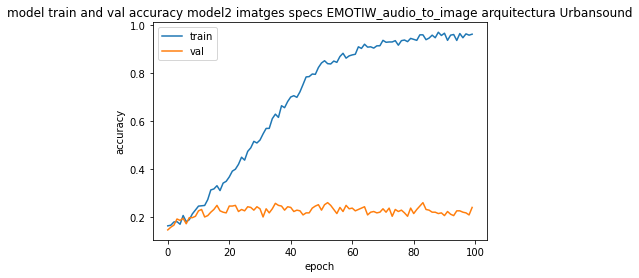

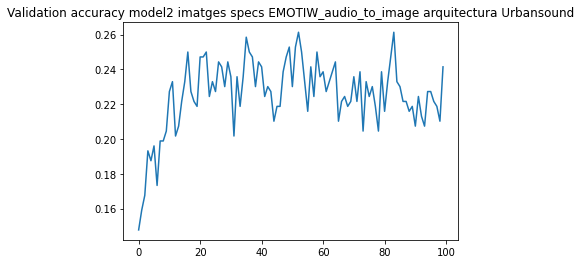

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_model(history,"model2 imatges specs EMOTIW_audio_to_image arquitectura Urbansound")
plt.figure()
# plt.plot(history.history["validation_accuracy"])



In [ ]:
print(history.history['accuracy'])
print(history.history['val_accuracy'])

Found 773 images belonging to 7 classes.
Found 381 images belonging to 7 classes.
VGG_summary:
[<keras.engine.input_layer.InputLayer object at 0x7f479bc6c510>, <keras.layers.convolutional.Conv2D object at 0x7f479c313610>, <keras.layers.convolutional.Conv2D object at 0x7f479bc33250>, <keras.layers.pooling.MaxPooling2D object at 0x7f479c313690>, <keras.layers.convolutional.Conv2D object at 0x7f479c2ae350>, <keras.layers.convolutional.Conv2D object at 0x7f479bc0a410>, <keras.layers.pooling.MaxPooling2D object at 0x7f479c2ae6d0>, <keras.layers.convolutional.Conv2D object at 0x7f479c2cf790>, <keras.layers.convolutional.Conv2D object at 0x7f479c2cf750>, <keras.layers.convolutional.Conv2D object at 0x7f472834d890>, <keras.layers.pooling.MaxPooling2D object at 0x7f4728345c10>, <keras.layers.convolutional.Conv2D object at 0x7f47283538d0>, <keras.layers.convolutional.Conv2D object at 0x7f472835b550>, <keras.layers.convolutional.Conv2D object at 0x7f472835b5d0>, <keras.layers.pooling.MaxPooling2D

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


24/24 [==============================] - 4s 121ms/step - loss: 2.1797 - accuracy: 0.1795 - categorical_accuracy: 0.1795 - val_loss: 1.8905 - val_accuracy: 0.2131 - val_categorical_accuracy: 0.2131
Epoch 2/60
24/24 [==============================] - 2s 94ms/step - loss: 2.0391 - accuracy: 0.1862 - categorical_accuracy: 0.1862 - val_loss: 1.8914 - val_accuracy: 0.2386 - val_categorical_accuracy: 0.2386
Epoch 3/60
24/24 [==============================] - 2s 92ms/step - loss: 2.0155 - accuracy: 0.1903 - categorical_accuracy: 0.1903 - val_loss: 1.8759 - val_accuracy: 0.2159 - val_categorical_accuracy: 0.2159
Epoch 4/60
24/24 [==============================] - 2s 96ms/step - loss: 1.9928 - accuracy: 0.1862 - categorical_accuracy: 0.1862 - val_loss: 1.8749 - val_accuracy: 0.2528 - val_categorical_accuracy: 0.2528
Epoch 5/60
24/24 [==============================] - 2s 93ms/step - loss: 1.9506 - accuracy: 0.2078 - categorical_accuracy: 0.2078 - val_loss: 1.8712 - val_accuracy: 0.2330 - val_cate

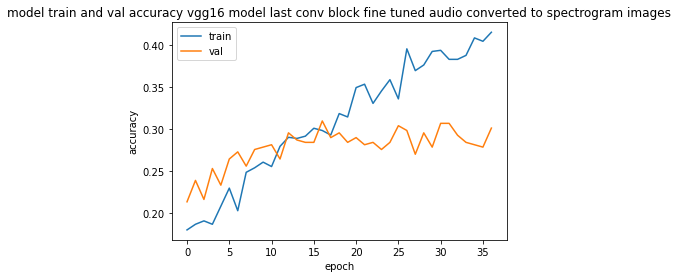

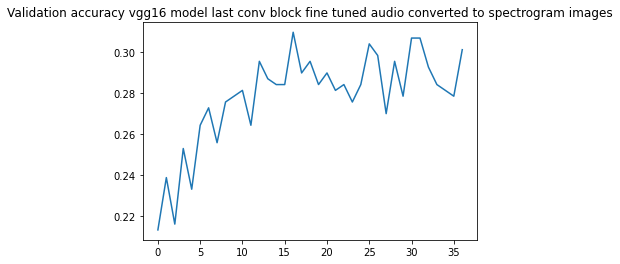

381
[[35  0  0 21  7  1  0]
 [10  0  0 16 11  3  0]
 [ 8  0  4 22  8  4  0]
 [12  0  1 29 17  4  0]
 [10  0  0 15 32  4  0]
 [ 9  0  2 23 18  9  0]
 [ 8  0  2 19 12  5  0]]

accuracy:  0.28608923884514437
f1 score: [0.44871795 0.         0.14545455 0.27884615 0.38554217 0.1978022
 0.        ]
f1 score weighted: 0.232441395948179
---------------------------------------------------------
vgg16 last conv block fine-tuned audio spectrogram images


<Figure size 432x288 with 0 Axes>

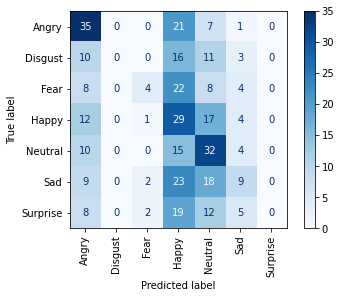

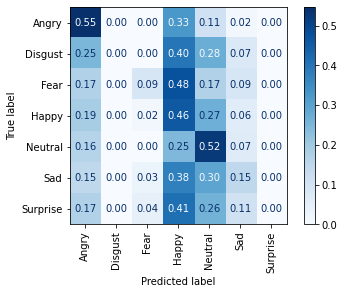

<Figure size 432x288 with 0 Axes>

In [ ]:
#Prova 2: No pre-emphasis

img_width, img_height=64,64
lr=1e-4
batch_size=32

train_generator,test_generator=create_sets(train_dir,test_dir,batch_size)
model_VGG_audio=create_model(8,dropout=0.5)
model_VGG_audio.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                metrics=['accuracy','categorical_accuracy'])

# path=filepath+"VGGTEST"+":{epoch:03d}-val_accuracy:{val_accuracy:.3f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                              min_delta=0,
                                              patience=20,
                                              verbose=1,
                                              mode="auto",
                                              restore_best_weights=True)
callback_list = [E_stopping]

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
# STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

history=model_VGG_audio.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_generator,
                    validation_steps=STEP_SIZE_TEST,
                    epochs=60,
                    callbacks=callback_list)
path=""
plot_model(history,"vgg16 model last conv block fine tuned audio converted to spectrogram images")
title="vgg16 last conv block fine-tuned audio spectrogram images"
plt.figure()
plot_conf_matrix(test_generator,model_VGG_audio,path,title,standard_format=True,percentages=True,save_plot=True)

In [ ]:
#TEST: prova arquitectura 2 amb preemphasis

In [ ]:
#PARAMS:
# lr=0.0005
# epochs=100
# preemphasis=False
# normalize=False
# desired_audio_len="no standarized"

# params={}
# params["num_prueba"]="Audio prueba modelo2"
# params["description"]="Test con espectrogramas convertidos en imágenes arquitectura de USound"
# params["DROPOUT"]=DROPOUT
# params["l2_regul"]=l2_regul
# params["learning rate"]=lr
# params["N_OUTPUT_LABELS"]=N_OUTPUT_LABELS
# params["batch_size"]=batch_size
# params["epochs"]=epochs
# params["desired_audio_len"]=desired_audio_len
# params["preemphasis"]=preemphasis
# params["normalize"]=normalize
# params["input_shape"]=input_shape
# params["accuracy"]=history.history['accuracy']
# params["val_accuracy"]=history.history['val_accuracy']

# import csv
# from csv import DictWriter

# with open("/content/gdrive/My Drive/TFM_MUSI/Audio/results.csv", 'a') as f: 
#   dictwriter_object = DictWriter(f, fieldnames=params.keys()) 
#   dictwriter_object.writeheader()
#   dictwriter_object.writerow(params) 
#   f.close()

In [ ]:
for audio_file in urls_afew_test:
  file_id=os.path.split(audio_file)[1].split(".")[0]
  label=dict_xy_afew[file_id]
  saving_file="spec_images/test/"+label+"/"+file_id
  create_spectrogram_test(audio_file,saving_file,preemphasis=True)

for audio_file in urls_afew_train:
  file_id=os.path.split(audio_file)[1].split(".")[0]
  label=dict_xy_afew[file_id]
  saving_file="spec_images/train/"+label+"/"+file_id
  create_spectrogram_test(audio_file,saving_file,preemphasis=True)

In [ ]:

train_dir= '/content/spec_images/train'
test_dir= '/content/spec_images/test'
train_generator,test_generator=create_sets(train_dir,test_dir)

Found 773 images belonging to 7 classes.
Found 381 images belonging to 7 classes.


In [ ]:
img_width, img_height=64,64
lr=1e-5
batch_size=16

train_generator,test_generator=create_sets(train_dir,test_dir,batch_size)
model_VGG_audio=create_model(8,dropout=0.5)
model_VGG_audio.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                metrics=['accuracy','categorical_accuracy'])

# path=filepath+"VGGTEST"+":{epoch:03d}-val_accuracy:{val_accuracy:.3f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                              min_delta=0,
                                              patience=20,
                                              verbose=1,
                                              mode="auto",
                                              restore_best_weights=True)
callback_list = [E_stopping]

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
# STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

history=model_VGG_audio.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_generator,
                    validation_steps=STEP_SIZE_TEST,
                    epochs=60,
                    callbacks=callback_list)

path=""
plot_model(history,"vgg16 model last conv block fine tuned audio converted to spectrogram images")
title="vgg16 last conv block fine-tuned audio spectrogram images"
plt.figure()
plot_conf_matrix(test_generator,model_VGG_audio,path,title,standard_format=True,percentages=True,save_plot=True)